In [1]:
import os
import fsspec
import tqdm

import datamol as dm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from mood.visualize import plot_distance_distributions
from mood.dataset import MOOD_DATASETS
from mood.representations import MOOD_REPRESENTATIONS

In [2]:
GLOB_PATTERN = "gs://experiments-output/mood-v2/results/numpy/compare_spaces/20221216/*.npy"

In [3]:
paths = dm.fs.glob(GLOB_PATTERN)
paths[:3]

['gcs://experiments-output/mood-v2/results/numpy/compare_spaces/20221216/BBB_ChemBERTa_Optimization_GP_space.npy',
 'gcs://experiments-output/mood-v2/results/numpy/compare_spaces/20221216/BBB_ChemBERTa_Optimization_MLP_space.npy',
 'gcs://experiments-output/mood-v2/results/numpy/compare_spaces/20221216/BBB_ChemBERTa_Optimization_RF_space.npy']

In [4]:
def load_as_dataframe(path):
    
    basename = dm.fs.get_basename(path)
    basename = os.path.splitext(basename)[0]
    dataset, representation, subset, space, _ = basename.split("_")
    
    with fsspec.open(path, "rb") as fd:
        distances = np.load(fd)
        
    df_ = pd.DataFrame({
        "Dataset": dataset,
        "Representation": representation,
        "Subset": subset.capitalize(),
        "Space": space,
        "Distances": [distances],
    }, index=[0])
    return df_


dfs = dm.utils.parallelized(load_as_dataframe, paths, progress=True, n_jobs=-1)

  0%|          | 0/768 [00:00<?, ?it/s]

/home/cas/mambaforge/envs/mood_v2/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/cas/mambaforge/envs/mood_v2/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more info

In [5]:
df = pd.concat(dfs, ignore_index=True)
df.head()

,Dataset,Representation,Subset,Space,Distances
0,BBB,ChemBERTa,Optimization,GP,"[10.78544867493246, 9.438141990033781, 10.0813..."
1,BBB,ChemBERTa,Optimization,MLP,"[11.378736860319142, 8.975960630014423, 10.277..."
2,BBB,ChemBERTa,Optimization,RF,"[10.448091788978147, 9.00250971597048, 10.6163..."
3,BBB,ChemBERTa,Optimization,input,"[21.47773003753199, 19.018381322352234, 21.218..."
4,BBB,ChemBERTa,Train,GP,"[6.77729720924593, 7.025933365583461, 6.863862..."


In [6]:
def plot(df, dataset, spaces, cols=None, rows=None):
    df = df[df["Dataset"] == dataset]
    df = df[df["Space"].isin(spaces)]
    
    if cols is None:
        cols = df["Space"].unique()
    if rows is None:
        rows = df["Representation"].unique()
    
    fig, axs = plt.subplots(ncols=len(cols), nrows=len(rows), figsize=(6 * len(cols), 3 * len(rows)))
    if axs.ndim < 2:
        axs = axs[:, np.newaxis]
    
    for ri, representation in enumerate(rows):
        for ci, space in enumerate(cols):
            
            group = df[df["Representation"] == representation]
            group = group[group["Space"] == space]
            
            if group.empty:
                axs[ri][ci].axis("off")
                continue
            
            group["Subset"] = pd.Categorical(group["Subset"], ["Train", "Virtual screening", "Optimization"])
            group = group.sort_values("Subset")
            
            distances = group["Distances"].tolist()
            labels = group["Subset"].tolist()
            
            ax = plot_distance_distributions(distances, labels=labels, ax=axs[ri][ci])
            
            if ci == 0: 
                x_min, x_max = ax.get_xlim()
                x = x_min - (x_max - x_min) / 10
                y_min, y_max = ax.get_ylim() 
                y = y_min + (y_max - y_min) / 2
                ax.text(x, y, representation, rotation="vertical", va="center")
            if ri == 0: 
                ax.set_title(f"{space} space")
            if ri == len(rows) - 1: 
                ax.set_xlabel("Distance")
            else: 
                ax.set_xlabel("")
    
    fig.suptitle(dataset, fontsize=18, y=1)
    plt.tight_layout()


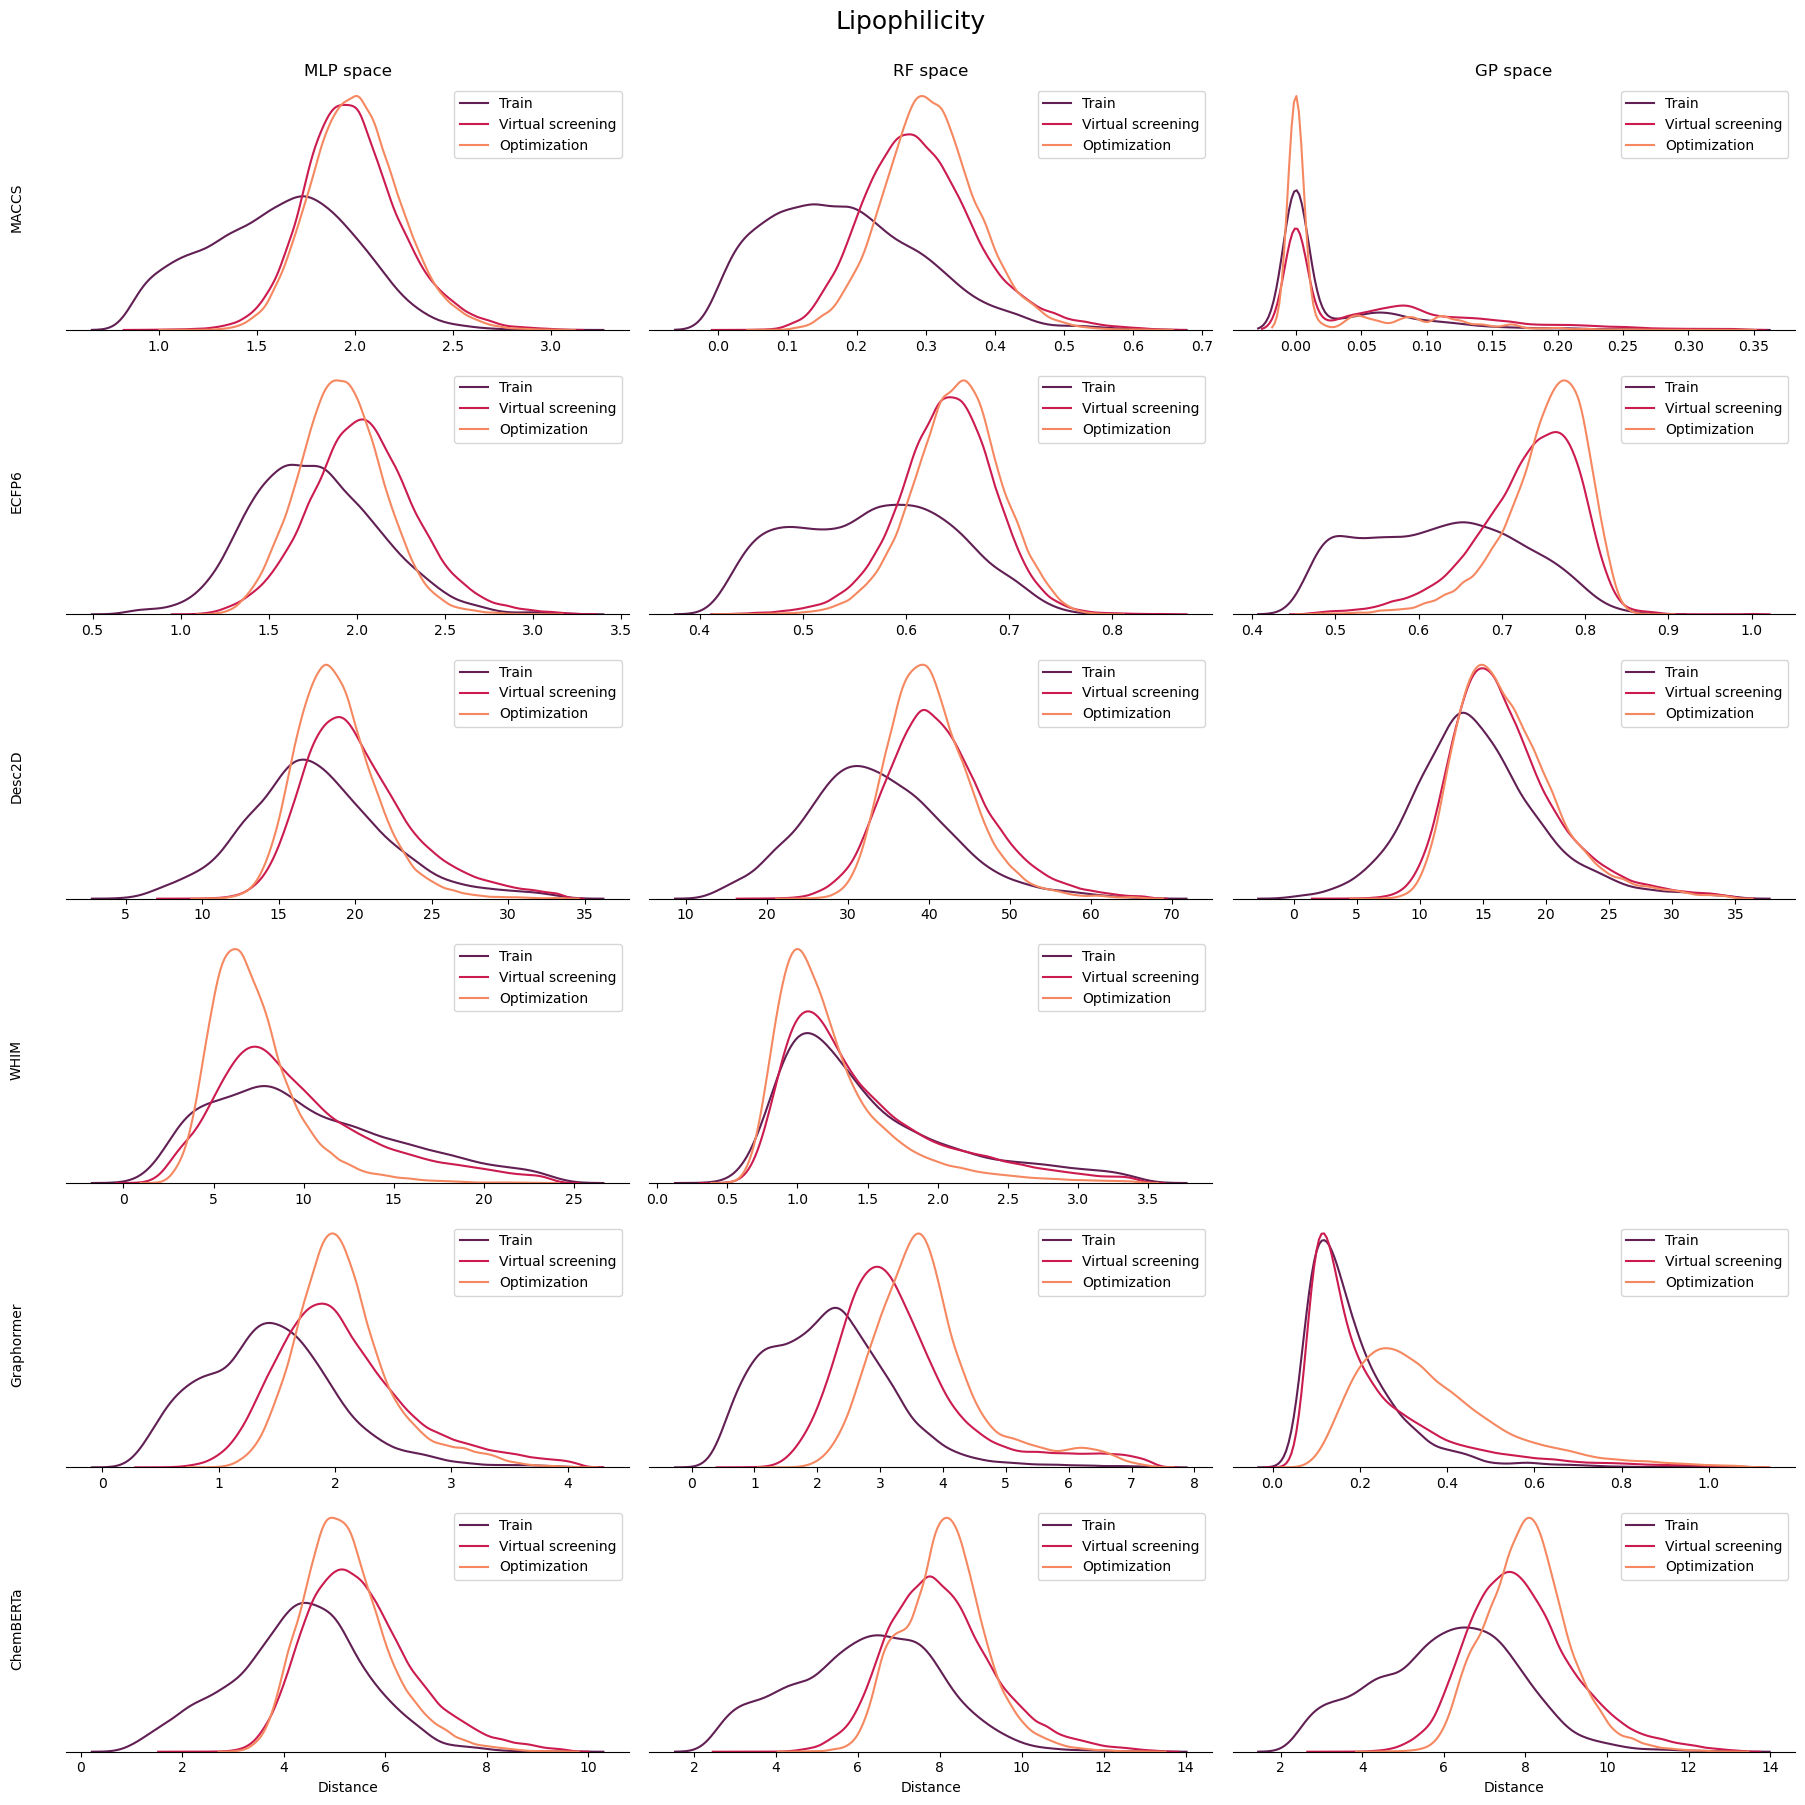

In [7]:
plot(df, "Lipophilicity", ["GP", "MLP", "RF"], cols=["MLP", "RF", "GP"], rows=["MACCS", "ECFP6", "Desc2D", "WHIM", "Graphormer", "ChemBERTa"])

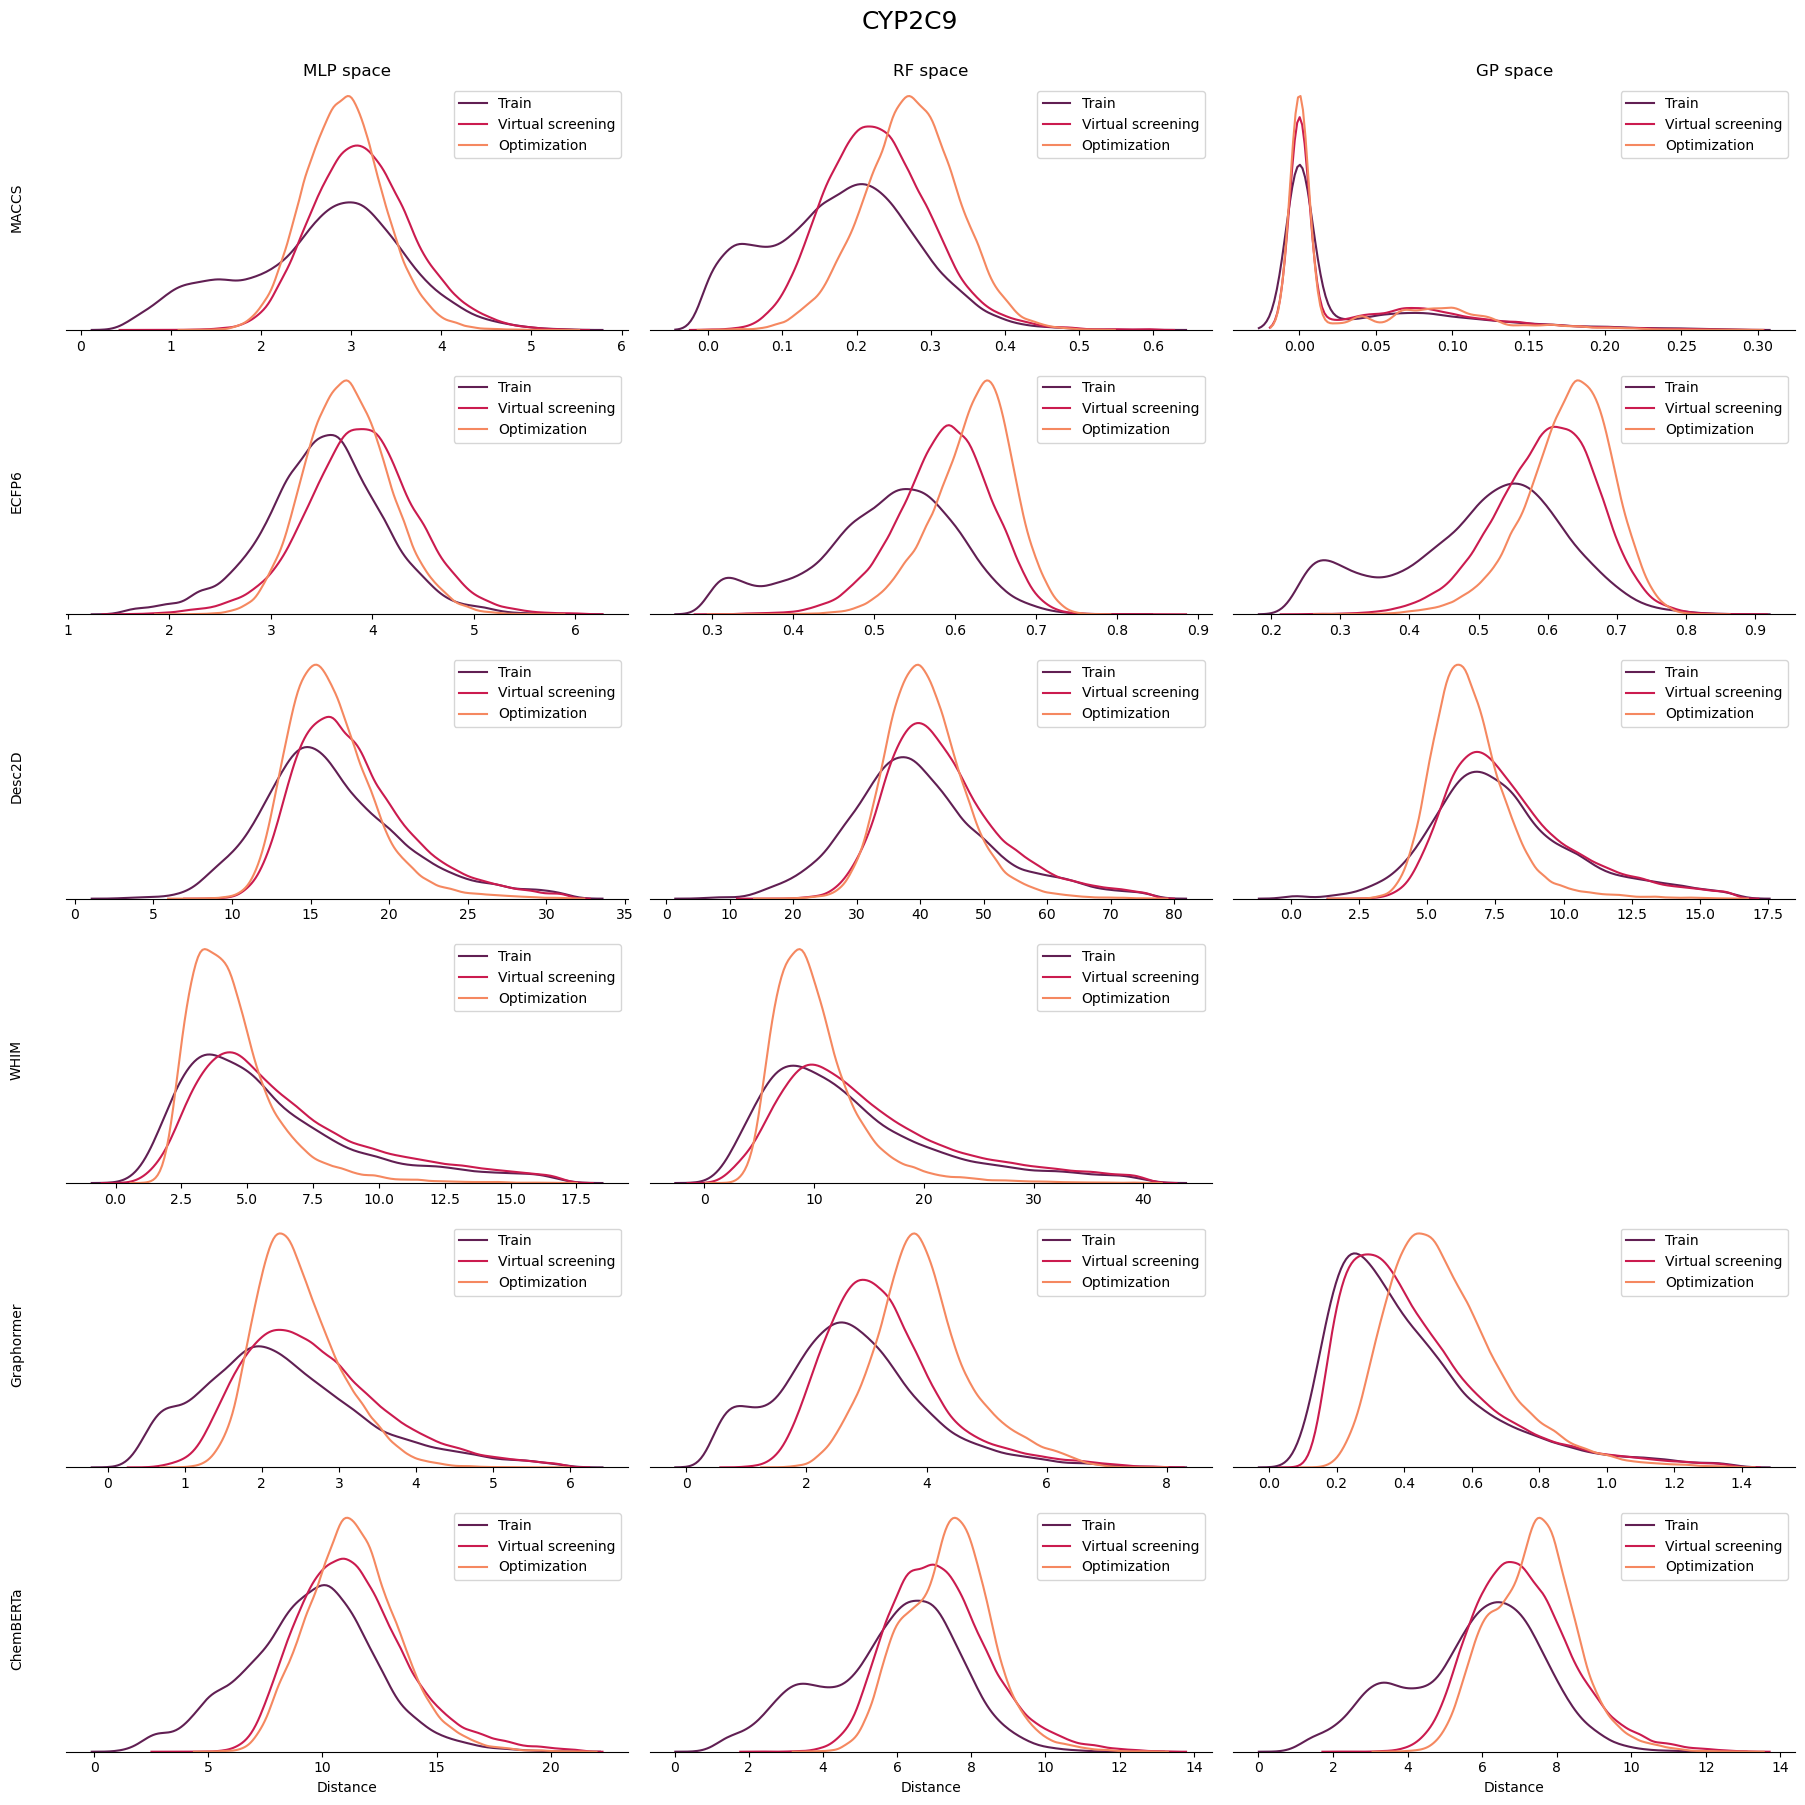

In [12]:
plot(df, "CYP2C9", ["GP", "MLP", "RF"], cols=["MLP", "RF", "GP"], rows=["MACCS", "ECFP6", "Desc2D", "WHIM", "Graphormer", "ChemBERTa"])

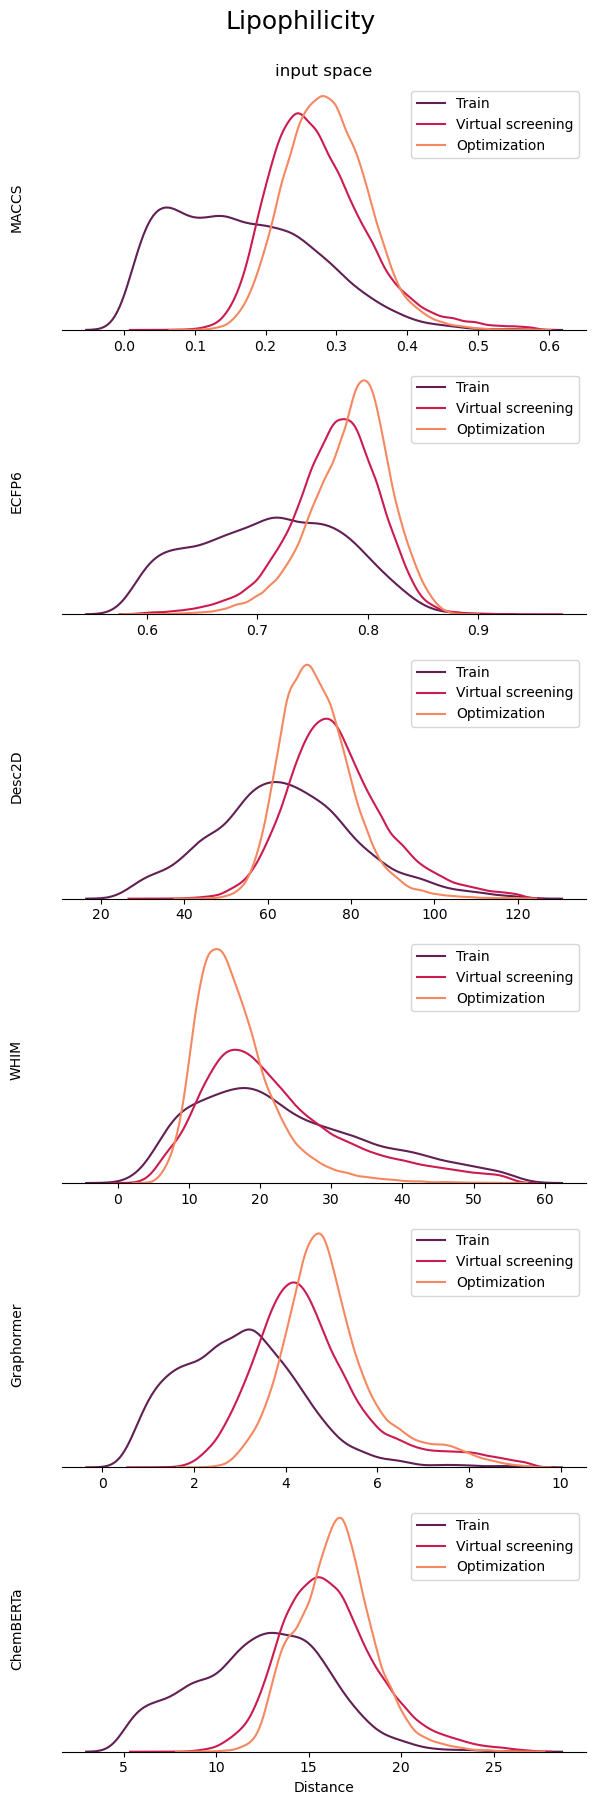

In [9]:
plot(df, "Lipophilicity", ["input"], cols=["input"], rows=["MACCS", "ECFP6", "Desc2D", "WHIM", "Graphormer", "ChemBERTa"])

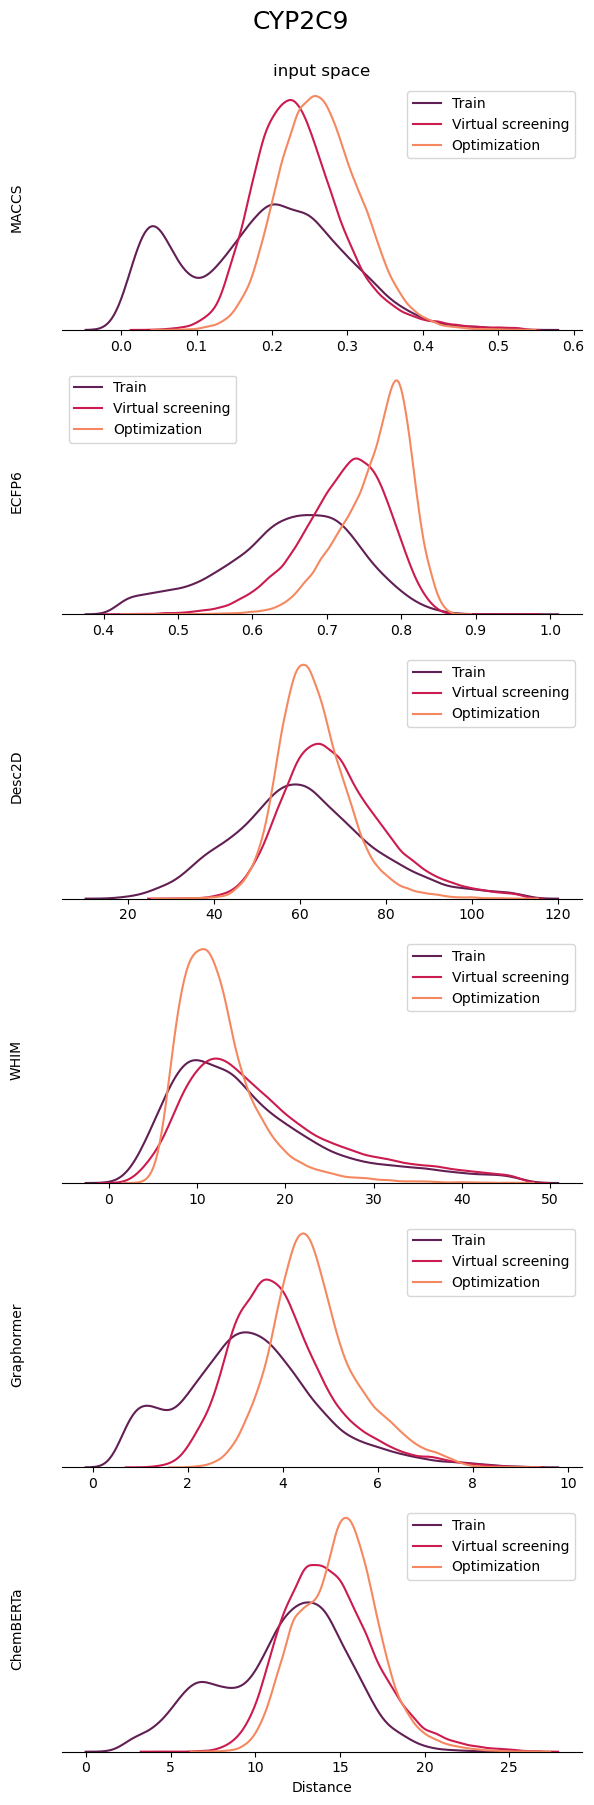

In [11]:
plot(df, "CYP2C9", ["input"], cols=["input"], rows=["MACCS", "ECFP6", "Desc2D", "WHIM", "Graphormer", "ChemBERTa"])

The End.